In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import joblib
import numpy as np
from matplotlib import pyplot as plt
from syd import make_viewer
from tqdm import tqdm

from vrAnalysis.database import get_database
from dimensionality_manuscript.registry import PopulationRegistry
from dimensionality_manuscript.workflows.compare_old_cvpca import (
    cvpca_integrated_comparison,
    get_legacy_cvpca,
    gather_cvpca_comparisons,
    CVPCAComparisonViewer,
)
from dimensionality_manuscript.workflows.measure_cvpca import get_filepath as get_cvpca_filepath

plt.rcParams["font.size"] = 18

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

In [16]:
# Evaluate whether RRR internals contain the information in the RBFPos internals
spks_type = "oasis"
svd_method = [True, False]
num_bins = 100

mouse_names = []
session_iterable = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))
num_sessions = len(session_iterable)
reg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
org_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
org_smooth_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
pca_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
pca_smooth_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
leg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
saved_leg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
for isvd, use_svd in enumerate(svd_method):
    for isession, session in enumerate(tqdm(session_iterable)):
        if isvd == 0:
            mouse_names.append(session.mouse_name)
        results_fpath = get_cvpca_filepath(session, use_svd=use_svd)
        if results_fpath.exists():
            results = joblib.load(results_fpath)
        else:
            continue
        
        c_reg_cov = results["reg_covariances"]
        c_org_cov = results["org_covariances"]
        c_org_cov_smooth = results["org_smooth_covariances"]
        c_pca_cov = results["pca_covariances"]
        c_pca_cov_smooth = results["pca_smooth_covariances"]
        c_leg_cov = results["leg_covariances"]
        c_saved_leg_cov = results["saved_leg_covariances"]
        reg_covariances[isvd, isession, :len(c_reg_cov)] = c_reg_cov
        org_covariances[isvd, isession, :len(c_org_cov)] = c_org_cov
        org_smooth_covariances[isvd, isession, :len(c_org_cov_smooth)] = c_org_cov_smooth
        pca_covariances[isvd, isession, :len(c_pca_cov)] = c_pca_cov
        pca_smooth_covariances[isvd, isession, :len(c_pca_cov_smooth)] = c_pca_cov_smooth
        leg_covariances[isvd, isession, :len(c_leg_cov)] = c_leg_cov
        if c_saved_leg_cov is not None:
            saved_leg_covariances[isvd, isession, :len(c_saved_leg_cov)] = c_saved_leg_cov
        session.clear_cache()

mice = list(set(mouse_names))
mouse_names = np.array(mouse_names)
avg_reg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_org_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_org_smooth_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_pca_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_pca_smooth_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_leg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_saved_leg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
for imouse, mouse in enumerate(mice):
    if np.sum(mouse_names == mouse) == 0:
        print(f"No sessions for {mouse}")
        continue
    
    avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
    avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
    avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_covariances[:, imouse] = np.nanmean(pca_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_smooth_covariances[:, imouse] = np.nanmean(pca_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_leg_covariances[:, imouse] = np.nanmean(leg_covariances[:, mouse_names == mouse], axis=1)
    avg_saved_leg_covariances[:, imouse] = np.nanmean(saved_leg_covariances[:, mouse_names == mouse], axis=1)

100%|██████████| 149/149 [00:01<00:00, 148.67it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_26308\410021937.py:63: RuntimeWarning: Mean of empty slice
  avg_saved_leg_covariances[:, imouse] = np.nanmean(saved_leg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_26308\410021937.py:57: RuntimeWarning: Mean of empty slice
  avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_26308\410021937.py:58: RuntimeWarning: Mean of empty slice
  avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_26308\410021937.py:59: RuntimeWarning: Mean of empty slice
  avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_26308\410021937.py:60: RuntimeWarning: Mean of empty slice
  avg_pca_covarianc

In [32]:
def norm(data):
    return data / np.nansum(np.abs(data), axis=1, keepdims=True)

def plot(state):
    xscale = state["xscale"]
    yscale = state["yscale"]

    if state["use_saved_legacy"]:
        plot_leg_covariances = avg_saved_leg_covariances
    else:
        plot_leg_covariances = avg_leg_covariances

    isvd = 0 if state["svd"] else 1

    idims = np.arange(num_bins) + 1
    plt.close('all')
    fig, ax = plt.subplots(1, 3, figsize=(9, 4), layout="constrained", sharex=True, sharey=True)
    ax[0].plot(idims, norm(avg_reg_covariances[isvd]).T)
    ax[1].plot(idims, norm(avg_org_covariances[isvd]).T)
    ax[2].plot(idims, norm(plot_leg_covariances[isvd]).T)
    ax[0].set_title("r-cvPCA")
    ax[1].set_title("cvPCA")
    ax[2].set_title("leg-cvPCA")
    ax[0].set_xscale(xscale)
    ax[1].set_xscale(xscale)
    ax[2].set_xscale(xscale)
    ax[0].set_yscale(yscale)
    ax[1].set_yscale(yscale)
    ax[2].set_yscale(yscale)
    ax[0].set_ylabel("Eigenvalue")

    ylims = state["ylims"]
    if state["yscale"] == "log":
        ylims = (10**ylims[0], 10**ylims[1])
    ax[0].set_ylim(ylims[0], ylims[1])

    return fig

def update_ylim_range(state):
    ylims = state["ylims"]
    if state["yscale"] == "log":
        min = -10
        max = 1
        new_value = (np.log10(ylims[0]), np.log10(ylims[1]))
    else:
        min = -0.05
        max = 1.0
        new_value = (10**ylims[0], 10**ylims[1])
    
    viewer.update_float_range("ylims", value=new_value, min=min, max=max)

viewer = make_viewer(plot)
viewer.add_selection("xscale", value="log", options=["linear", "log"])
viewer.add_selection("yscale", value="log", options=["linear", "log"])
viewer.add_boolean("use_saved_legacy")
viewer.add_boolean("svd", value=False)
viewer.add_float_range("ylims", value=(-6, 0), min=-10, max=10)
viewer.on_change("yscale", update_ylim_range)
# viewer.show()

In [ ]:
spks_type = "oasis"
num_bins = 100

session = sessiondb.iter_sessions(imaging=True)[14]
session_name = session.session_print()

results, intermediate_results = gather_cvpca_comparisons(
    session=session,
    spks_type=spks_type,
    num_bins=num_bins,
    pre_average=True,
    smooth_width=None,
    normalize=False,
    center=True,
)

# results = cvpca_integrated_comparison(
#     session=session,
#     spks_type=spks_type,
#     num_bins=num_bins,
#     smooth_width = None,
#     normalize=False,
#     center=True,
#     shuffle_fraction=0.5,
# )

# legacy_result = get_legacy_cvpca(session, results["best_env_idx"])

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from dimensionality_manuscript.workflows.compare_old_cvpca import (
    cvpca_integrated_comparison,
    get_legacy_cvpca,
    gather_cvpca_comparisons,
    CVPCAComparisonViewer,
)

In [ ]:
viewer = CVPCAComparisonViewer()
viewer.show()

In [ ]:
# For looking at trial by position maps of individual neurons (only relevant when not using pre-averaged data!)
import matplotlib as mpl

def plot(state):
    fold_idx = state["fold_idx"]
    neuron_idx = state["neuron_idx"]

    pfdata = intermediate_results["pf_data_from_placefields"][fold_idx][neuron_idx]
    smdata = intermediate_results["spkmap_from_pcss"][fold_idx][neuron_idx]

    pfdata = pfdata / np.nanmax(pfdata)
    smdata = smdata / np.nanmax(smdata)

    pfmean = np.nanmean(pfdata, axis=0)
    smmean = np.nanmean(smdata, axis=0)

    if state["nan_to_zero"]:
        pfdata[np.isnan(pfdata)] = 0
        smdata[np.isnan(smdata)] = 0

    cmap = mpl.colormaps["gray"]
    cmap.set_bad(("yellow", 0.2))
    fig, ax = plt.subplots(2, 2, height_ratios=[2, 1], figsize=(8, 4), layout="constrained")
    ax[0, 0].imshow(pfdata, cmap=cmap, vmin=0, vmax=1)
    ax[0, 1].imshow(smdata, cmap=cmap, vmin=0, vmax=1)
    ax[1, 0].plot(pfmean, linewidth=1.5)
    ax[1, 1].plot(smmean, linewidth=1.5)
    return fig

viewer = make_viewer(plot)
viewer.add_integer("fold_idx", value=0, min=0, max=len(intermediate_results["pf_data_from_placefields"])-1)
viewer.add_integer("neuron_idx", value=0, min=0, max=len(intermediate_results["pf_data_from_placefields"][0])-1)
viewer.add_boolean("nan_to_zero", value=False)
viewer.show()

KeyError: 'pf_data_from_placefields'

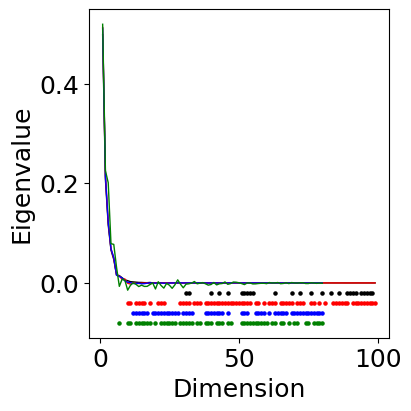

In [13]:
env_idx = results["best_env_idx"]
num_org = len(results["org_covariances"])
num_leg = len(results["leg_covariances"])
num_true_leg = len(results["true_leg_covariances"])
num_saved_leg = len(legacy_result["cv_by_env_all"])

neg_org = np.where(results["org_covariances"] < 0)[0] + 1
neg_leg = np.where(results["leg_covariances"] < 0)[0] + 1
neg_true_leg = np.where(results["true_leg_covariances"] < 0)[0] + 1
neg_saved_leg = np.where(legacy_result["cv_by_env_all"] < 0)[0] + 1

xorg = range(1, num_org + 1)
xleg = range(1, num_leg + 1)
xtrue_leg = range(1, num_true_leg + 1)
xsaved_leg = range(1, num_saved_leg + 1)
norm = lambda x: x / np.sum(x)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
ax.plot(xorg, norm(results["org_covariances"]), color="k", linewidth=1.0)
ax.plot(xleg, norm(results["leg_covariances"]), color="r", linewidth=1.0)
ax.plot(xtrue_leg, norm(results["true_leg_covariances"]), color="b", linewidth=1.0)
ax.plot(xsaved_leg, norm(legacy_result["cv_by_env_all"]), color="g", linewidth=1.0)
ax.scatter(neg_org, -0.02*np.ones(len(neg_org)), color="k", s=5)
ax.scatter(neg_leg, -0.04*np.ones(len(neg_leg)), color="r", s=5)
ax.scatter(neg_true_leg, -0.06*np.ones(len(neg_true_leg)), color="b", s=5)
ax.scatter(neg_saved_leg, -0.08*np.ones(len(neg_saved_leg)), color="g", s=5)
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_ylim(1e-6, 1e0)
ax.set_xlabel("Dimension")
ax.set_ylabel("Eigenvalue")
plt.show()